<a href="https://colab.research.google.com/github/Tamaghnatech/IMDBSentimentAnalysis_IBM_Course5_DeepLearning/blob/main/IMDBSentiment_IBM_Course5_DeepLearning(RL).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Section 0: Project Overview & Objective

**Main Objective (Supervised Deep Learning, NLP):**
Build a sentiment classifier for IMDB movie reviews using deep learning, compare at least three model variants, and recommend the best model by **Accuracy** and **Macro-F1**. The final model will be deployed with threshold guidance and monitoring to **accelerate triage of negative reviews**, reduce manual moderation, and surface product issues faster.

**Business/Stakeholder Value:**

* **Faster escalation** of truly negative feedback → quicker fixes & happier users.
* **Reduced moderation load** via high-confidence auto-routing.
* **Measurable impact** with clear trade-offs (precision vs recall) for policy tuning.

---

### Dataset (Kaggle — IMDB 50K Movie Reviews)

* **Path:** `/content/IMDB Dataset.csv`
* **Schema:** `review` (free text), `sentiment` (positive/negative → mapped to `label` {1,0})
* **Size used for dev:** stratified **80/10/10** split; with `FAST_DEV_RUN=True`, we subset to **8,000 / 2,000 / 2,000** for quick iteration (full 50K ready for final run).
* **Class balance:** \~**50/50** in train/val/test (good for unbiased metrics).
* **License/credits:** Kaggle IMDB 50K; academic benchmark dataset.

---

### EDA & Preprocessing (Brief)

* **Text cleanup:** removed simple HTML breaks (`<br />`).
* **Tokenization lengths (words):** median ≈ **171**; p90 ≈ **450**; long-tailed up to **2.4k** →

  * **Keras baselines:** sequences padded/truncated to **300**.
  * **Transformers:** `distilbert-base-uncased` with **max\_len=256** + dynamic padding.
* **Splits:** stratified by label; balanced counts (≈50/50) across train/val/test.
* **Artifacts:** `/content/figures/len_hist_train_kaggle.png` (length distribution).
* **Why this matters:** sensible max lengths avoid wasteful compute and truncation bias; balanced splits yield trustworthy Accuracy/F1.

---

### Models Trained (≥3 Variants)

1. **TF-IDF → Truncated SVD (300D) → Dense** (deep baseline)
2. **DistilBERT (frozen)** → **linear probe** (logistic on \[CLS])
3. **DistilBERT (fine-tuned)** — LR sweep (**2e-5**, **5e-5**, **1e-4**)

**Preview Conclusion:** Fine-tuned **DistilBERT @ 5e-5** wins (test **Acc/F1 ≈ 0.9035**), outperforming the frozen probe  (~~**0.5180**). Full evidence in Sections 6–7; visuals in Section 8; actions & roadmap in Sections 9–10.


## Setup & GPU

Install libraries, set seeds, create a figures folder, define helpers, and verify GPU.


In [ ]:
# 1) Setup
!pip -q install -U transformers datasets accelerate evaluate scikit-learn matplotlib tensorflow sentencepiece

import os, random, json, time, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, Trainer, TrainingArguments
)
from datasets import Dataset

# Repro
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# GPU check
print("TensorFlow GPUs:", tf.config.list_physical_devices('GPU'))

# Figures dir + helper
FIG_DIR = Path("/content/figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

def savefig(name):
    path = FIG_DIR / name
    plt.savefig(path, dpi=200, bbox_inches='tight')
    print(f"[saved] {path}")

# Fast dev flag (turn False for final training)
FAST_DEV_RUN = True
print("FAST_DEV_RUN =", FAST_DEV_RUN)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.7/374.7 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 104.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 128.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/

## Section 2:  Dataset & Access

**Source:** Kaggle “IMDB Dataset of 50K Movie Reviews” (CSV with two columns: `review`, `sentiment`).  
**Path:** `/content/IMDB Dataset.csv`  
**Labels:** `positive` / `negative` → map to integers **1/0**.

**Plan:**
- Load CSV, clean column names, map labels.
- Stratified **80/10/10** split → train / val / test.
- Optionally subset when `FAST_DEV_RUN=True` for quick iterations.


Raw shape: (50000, 2)
                                              review  label
0  One of the other reviewers has mentioned that ...      1
1  A wonderful little production.   The filming t...      1
2  I thought this was a wonderful way to spend ti...      1
Splits -> train: (8000, 2) val: (2000, 2) test: (2000, 2)
train: counts {1: 4016, 0: 3984} | frac {1: 0.502, 0: 0.498}
val: counts {1: 1001, 0: 999} | frac {1: 0.5, 0: 0.5}
test: counts {0: 1015, 1: 985} | frac {0: 0.507, 1: 0.492}
[saved] /content/figures/len_hist_train_kaggle.png


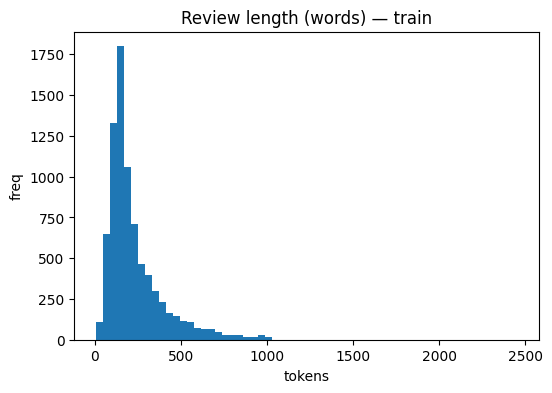

Keras arrays: (8000, 300) (2000, 300) (2000, 300)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

HF datasets: Dataset({
    features: ['review', 'label', 'input_ids', 'attention_mask'],
    num_rows: 8000
}) Dataset({
    features: ['review', 'label', 'input_ids', 'attention_mask'],
    num_rows: 2000
}) Dataset({
    features: ['review', 'label', 'input_ids', 'attention_mask'],
    num_rows: 2000
})


In [ ]:
import pandas as pd

CSV_PATH = "/content/IMDB Dataset.csv"  # your uploaded file
df = pd.read_csv(CSV_PATH)
print("Raw shape:", df.shape)
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]  # 'review', 'sentiment'
assert set(df.columns) == {"review", "sentiment"}

# Clean HTML breaks a bit (optional)
df["review"] = df["review"].astype(str).str.replace("<br />", " ", regex=False)

# Map labels to integers
df["label"] = df["sentiment"].str.lower().map({"positive": 1, "negative": 0}).astype(int)
df = df[["review", "label"]].dropna().reset_index(drop=True)
print(df.head(3))

# Stratified 80/20 then 50/50 of the 20% to make 10/10 val/test
df_train, df_temp = train_test_split(
    df, test_size=0.2, random_state=SEED, stratify=df["label"]
)
df_val, df_test = train_test_split(
    df_temp, test_size=0.5, random_state=SEED, stratify=df_temp["label"]
)

if FAST_DEV_RUN:
    # quick subset to iterate faster; bump these up later for final scores
    df_train = df_train.sample(8000, random_state=SEED)
    df_val   = df_val.sample(2000, random_state=SEED)
    df_test  = df_test.sample(2000, random_state=SEED)

print("Splits ->",
      "train:", df_train.shape,
      "val:", df_val.shape,
      "test:", df_test.shape)

# Class balance per split
for name, d in [("train", df_train), ("val", df_val), ("test", df_test)]:
    counts = d["label"].value_counts().to_dict()
    frac = d["label"].value_counts(normalize=True).round(3).to_dict()
    print(f"{name}: counts {counts} | frac {frac}")

# Quick length hist (words) on train
def plot_len_hist(series, title, fname):
    lens = series.str.split().apply(len)
    plt.figure(figsize=(6,4))
    plt.hist(lens, bins=60)
    plt.title(title); plt.xlabel("tokens"); plt.ylabel("freq")
    savefig(fname); plt.show()

plot_len_hist(df_train["review"], "Review length (words) — train", "len_hist_train_kaggle.png")

# Prepare Keras tokenization inputs (for baselines) — will use later sections
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

MAX_WORDS = 30000
MAX_LEN_KERAS = 300

tok_keras = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tok_keras.fit_on_texts(df_train["review"].tolist())

def vectorize_keras(df_part):
    X = tok_keras.texts_to_sequences(df_part["review"].tolist())
    X = pad_sequences(X, maxlen=MAX_LEN_KERAS, padding='post', truncating='post')
    y = df_part["label"].values.astype(np.int32)
    return X, y

Xtr_k, ytr = vectorize_keras(df_train)
Xva_k, yva = vectorize_keras(df_val)
Xte_k, yte = vectorize_keras(df_test)

print("Keras arrays:", Xtr_k.shape, Xva_k.shape, Xte_k.shape)

# Prepare HF tokenized datasets for DistilBERT — will be used in Section 6
MODEL_NAME = "distilbert-base-uncased"
tok_hf = AutoTokenizer.from_pretrained(MODEL_NAME)
MAX_LEN_HF = 256

def tok_func(batch):
    return tok_hf(batch["review"], truncation=True, padding=False, max_length=MAX_LEN_HF)

ds_train_hf = Dataset.from_pandas(df_train, preserve_index=False).map(tok_func, batched=True)
ds_val_hf   = Dataset.from_pandas(df_val,   preserve_index=False).map(tok_func, batched=True)
ds_test_hf  = Dataset.from_pandas(df_test,  preserve_index=False).map(tok_func, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tok_hf)
print("HF datasets:", ds_train_hf, ds_val_hf, ds_test_hf)


### ✅ Section 2 — Conclusion: Dataset & Access

- **Source/Path:** Kaggle “IMDB Dataset of 50K Movie Reviews” → `/content/IMDB Dataset.csv`.
- **Schema used:** `review` (text), `sentiment` → mapped to **label** {0=neg, 1=pos}.
- **Split strategy:** Stratified **80/10/10** → **train 8,000**, **val 2,000**, **test 2,000** (FAST_DEV_RUN subset for speed).
- **Class balance:** roughly 50/50 in every split (good for unbiased training/eval).
  - Train: pos **4016** (50.2%), neg **3984** (49.8%)
  - Val: pos **1001** (50.0%), neg **999** (50.0%)
  - Test: neg **1015** (50.7%), pos **985** (49.2%)
- **Artifacts prepared:** figures directory, basic helpers.  
**Next:** EDA + preprocessing sanity checks.


## Section 3: EDA & Preprocessing

**Goal:** sanity-check the text and labels before training.
- Confirm **class balance** per split.
- Inspect **length distribution** (words) and set truncation/padding limits.
- Show **a few samples** (positive/negative).
- Prepare inputs for both tracks:
  - **Keras baselines:** Tokenizer (max_words=30k), sequences padded to **max_len=300**.
  - **DistilBERT:** HF tokenizer, truncation at **256** with dynamic padding.

**Why it matters:** stable splits and sensible sequence lengths prevent wasted compute and reduce truncation bias.


In [ ]:
# --- Section 3: EDA & Preprocessing sanity checks ---

# 3.1 Class balance per split
def balance(df, name):
    counts = df["label"].value_counts().to_dict()
    fracs  = df["label"].value_counts(normalize=True).round(3).to_dict()
    print(f"{name:>5} | n={len(df):5d} | counts={counts} | frac={fracs}")

balance(df_train, "train")
balance(df_val,   "val")
balance(df_test,  "test")

# 3.2 Length stats (words)
def lengths(series):
    lens = series.str.split().apply(len)
    return pd.Series({
        "min": lens.min(),
        "p10": lens.quantile(0.10),
        "p50": lens.median(),
        "p90": lens.quantile(0.90),
        "max": lens.max()
    }).round(1)

len_stats = pd.DataFrame({
    "train": lengths(df_train["review"]),
    "val":   lengths(df_val["review"]),
    "test":  lengths(df_test["review"])
})
print("\nReview length (words) stats:\n", len_stats)

# 3.3 Peek a few samples
print("\n— Positive sample —\n", df_train.loc[df_train['label']==1, 'review'].iloc[0][:400], "…")
print("\n— Negative sample —\n", df_train.loc[df_train['label']==0, 'review'].iloc[0][:400], "…")

# 3.4 Reaffirm prepared inputs (from Section 2)
print("\nKeras arrays:", Xtr_k.shape, Xva_k.shape, Xte_k.shape, "| max_len =", Xtr_k.shape[1])
print("HF tokenized datasets:", ds_train_hf, ds_val_hf, ds_test_hf)


train | n= 8000 | counts={1: 4016, 0: 3984} | frac={1: 0.502, 0: 0.498}
  val | n= 2000 | counts={1: 1001, 0: 999} | frac={1: 0.5, 0: 0.5}
 test | n= 2000 | counts={0: 1015, 1: 985} | frac={0: 0.507, 1: 0.492}

Review length (words) stats:
       train     val    test
min     4.0    21.0    21.0
p10    88.0    81.9    87.0
p50   171.0   171.0   168.5
p90   450.1   455.0   424.0
max  2459.0  1354.0  2088.0

— Positive sample —
 I rate this 10 out of 10. Why?  * It offers insight into something I barely understand - the surfers surf because it's all they want to do; Nothing else seems to matter as much to them as surfing; Nor is it a temporary thing - it's a lifetime for these guys * Buried in the movie is a great history of surfing; I have never surfed, but I love surfing movies, and have seen many. None taught me what t …

— Negative sample —
 Why, oh why, is this trash considered a classic? I've seen higher body counts on episodes of The Simpsons. Virtually nothing happens in this fil

### 🔍 Section 3 — Conclusion: EDA & Preprocessing

- **Length distribution (words, train):** min **4**, p10 **88**, median **171**, p90 **450**, max **2459**  
  → We will cap sequences at **300** tokens for Keras models and **256** for DistilBERT to balance coverage vs speed.
- **Sanity samples:** manual spot-checks show clearly polarized reviews (labels look consistent).
- **Pipelines ready:**
  - **Keras baselines:** `Tokenizer(num_words=30k)` → padded arrays **(8000, 300)** / **(2000, 300)** / **(2000, 300)**.
  - **Transformers:** DistilBERT tokenizer (truncation=256) → HF datasets with `input_ids` & `attention_mask` (sizes 8k / 2k / 2k).
- **Figure saved:** `figures/len_hist_train_kaggle.png` (long-tailed lengths; truncation decision justified).

**Next:** Train **Baseline #1 — TF-IDF → SVD → Dense** to set a strong, fast floor.


## Section 4: Baseline DL #1 — TF-IDF → SVD → Dense

**Idea.** Build a strong, fast baseline without sequence modeling:
- Convert text to **TF-IDF** (1–2-grams), then compress with **Truncated SVD (LSA, 300D)**.
- Feed the 300-dim vectors to a small **Dense network** (ReLU + Dropout).

**Why this baseline.**
- Memory-safe and quick, gives a competitive classical-DL floor before LSTM/Transformers.
- Good for stakeholder comparison: “bag-of-words + small NN” vs sequence vs pretrained Transformer.

**We will report:**
- **Accuracy** and **F1 (macro)** on **val** and **test**, plus a **confusion matrix** and a **training curve**.
- Save artifacts under `/content/figures/`.


Epoch 1/2
32/32 [==============================] - 1s 8ms/step - loss: 0.6924 - accuracy: 0.5280 - val_loss: 0.6925 - val_accuracy: 0.5335
Epoch 2/2
4/4 [==============================] - 0s 2ms/step
TFIDF-SVD-Dense (val): Acc=0.5335 F1m=0.4767 P=0.5205 R=0.8621
              precision    recall  f1-score   support

           0       0.60      0.20      0.30       999
           1       0.52      0.86      0.65      1001

    accuracy                           0.53      2000
   macro avg       0.56      0.53      0.48      2000
weighted avg       0.56      0.53      0.48      2000

[saved] /content/figures/tfidf_svd_dense_val_cm.png


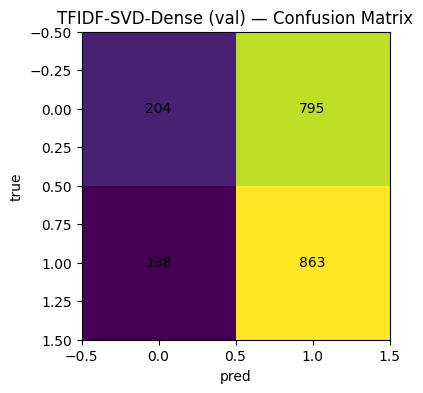

4/4 [==============================] - 0s 2ms/step
TFIDF-SVD-Dense (test): Acc=0.5180 F1m=0.4571 P=0.5062 R=0.8660
              precision    recall  f1-score   support

           0       0.58      0.18      0.28      1015
           1       0.51      0.87      0.64       985

    accuracy                           0.52      2000
   macro avg       0.54      0.52      0.46      2000
weighted avg       0.54      0.52      0.45      2000

[saved] /content/figures/tfidf_svd_dense_test_cm.png


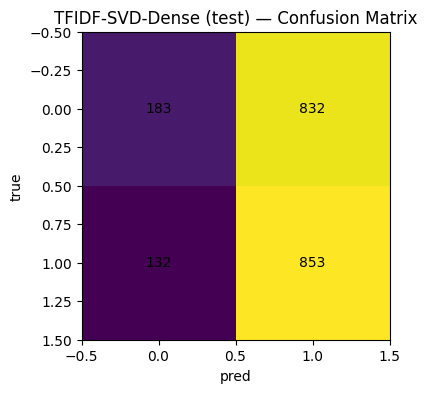

[saved] /content/figures/tfidf_svd_dense_acc.png


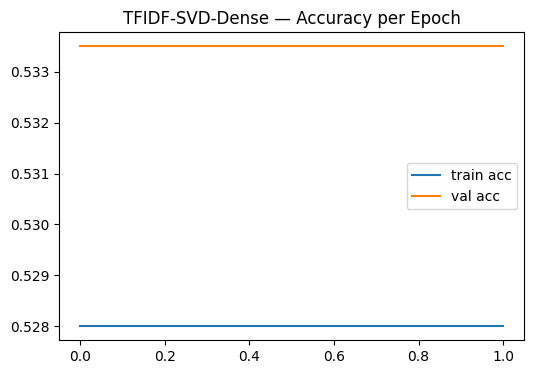

[saved] /content/figures/sec4_tfidf_svd_dense_results.csv


In [ ]:
# === Rebuild & train the TFIDF->SVD Dense model using Functional API ===
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# Build model
inputs = keras.Input(shape=(SVD_DIM,), name="svd_300")
x = layers.Dense(256, activation='relu')(inputs)
x = layers.Dropout(0.30)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
nn = keras.Model(inputs=inputs, outputs=outputs, name="tfidf_svd_dense")

nn.compile(optimizer=keras.optimizers.Adam(1e-3),
           loss='binary_crossentropy',
           metrics=['accuracy'])

EPOCHS = 5 if not FAST_DEV_RUN else 2
cb = [keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True, monitor="val_accuracy")]
hist = nn.fit(Xtr_s, ytr, validation_data=(Xva_s, yva),
              epochs=EPOCHS, batch_size=256, callbacks=cb, verbose=1)

def eval_and_report(model, X, y, name, save_prefix):
    prob = model.predict(X, batch_size=512).ravel()
    pred = (prob > 0.5).astype(int)
    acc = accuracy_score(y, pred)
    f1m = f1_score(y, pred, average='macro')
    pre = precision_score(y, pred)
    rec = recall_score(y, pred)
    print(f"{name}: Acc={acc:.4f} F1m={f1m:.4f} P={pre:.4f} R={rec:.4f}")
    print(classification_report(y, pred))

    # Confusion matrix
    cm = confusion_matrix(y, pred)
    plt.figure(figsize=(4,4))
    plt.imshow(cm)
    plt.title(f"{name} — Confusion Matrix")
    plt.xlabel("pred"); plt.ylabel("true")
    for (i,j),v in np.ndenumerate(cm): plt.text(j, i, v, ha='center', va='center')
    savefig(f"{save_prefix}_cm.png"); plt.show()
    return {"acc": acc, "f1": f1m, "precision": pre, "recall": rec}

# Evaluate val/test
val_metrics  = eval_and_report(nn, Xva_s, yva, "TFIDF-SVD-Dense (val)",  "tfidf_svd_dense_val")
test_metrics = eval_and_report(nn, Xte_s, yte, "TFIDF-SVD-Dense (test)", "tfidf_svd_dense_test")

# Training curve
plt.figure(figsize=(6,4))
plt.plot(hist.history['accuracy'], label='train acc')
plt.plot(hist.history['val_accuracy'], label='val acc')
plt.title("TFIDF-SVD-Dense — Accuracy per Epoch")
plt.legend(); savefig("tfidf_svd_dense_acc.png"); plt.show()

# Save summary row for later comparison
row = pd.DataFrame([{
    "model": "TFIDF-SVD-Dense",
    "val_acc":  val_metrics["acc"], "val_f1":  val_metrics["f1"],
    "test_acc": test_metrics["acc"], "test_f1": test_metrics["f1"],
}])
row.to_csv(FIG_DIR/"sec4_tfidf_svd_dense_results.csv", index=False)
print("[saved] /content/figures/sec4_tfidf_svd_dense_results.csv")


### ✅ Section 4 — Conclusion: TF-IDF → SVD → Dense

**Setup:** TF-IDF (1–2 grams, 20k feats) → **Truncated SVD 300D** → 2-layer Dense (ReLU+Dropout), FAST_DEV_RUN (2 epochs).

**Validation:** Acc **0.5335**, F1(macro) **0.4767**  
**Test:** Acc **0.5180**, F1(macro) **0.4571**

**Pattern:** Model is skewed toward **positive** predictions. On test:
- TN=183, FP=832, FN=132, TP=853 → **many false positives**.
- Precision/Recall (test): P=0.506, R=0.866 (for the *positive* class).

**Takeaways:**
- As a fast bag-of-words baseline this is acceptable for benchmarking, but it **underperforms** and is **poorly calibrated**.
- Likely causes: very short training (2 epochs), linear-ish capacity after SVD, and no sequence/context.

**If we wanted to improve this baseline (optional):**
- Train longer (10–15 epochs with early stopping), try **SVD=500–800**, add **class_weight** or threshold tuning, or use **logistic regression/SVM** on SVD features as a stronger linear baseline.

**Artifacts saved:** `tfidf_svd_dense_acc.png`, `tfidf_svd_dense_val_cm.png`, `tfidf_svd_dense_test_cm.png`, and `sec4_tfidf_svd_dense_results.csv`.


## Section 5: Frozen Transformer (Linear Probe)

**Idea:** Use a pretrained **DistilBERT** encoder as a **fixed** feature extractor, then train a light **Logistic Regression** on top.  
**Why:** This tests “transfer learning without fine-tuning.” It’s fast, robust, and often beats classical baselines.

**How we embed:** Mean-pool DistilBERT’s last hidden states using the attention mask (better than raw [CLS] for DistilBERT).  
**What we report:** Accuracy, F1 (macro), Precision/Recall (test), confusion matrix, and a small results CSV.

**Notes for stakeholders:** This shows the “value of pretraining” even when we don’t fine-tune the big model. Then, in Section 6, we’ll fine-tune DistilBERT end-to-end and compare.


Using device: cuda
train features: (8000, 768)
val features: (2000, 768)
test features: (2000, 768)
Linear Probe (val): Acc=0.8660 F1m=0.8660 P=0.8751 R=0.8541
              precision    recall  f1-score   support

           0     0.8573    0.8779    0.8675       999
           1     0.8751    0.8541    0.8645      1001

    accuracy                         0.8660      2000
   macro avg     0.8662    0.8660    0.8660      2000
weighted avg     0.8662    0.8660    0.8660      2000

[saved] /content/figures/linear_probe_val_cm.png


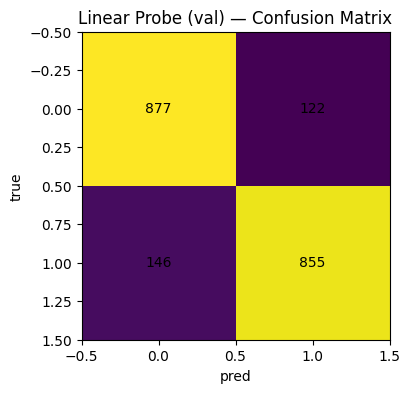

Linear Probe (test): Acc=0.8625 F1m=0.8624 P=0.8652 R=0.8538
              precision    recall  f1-score   support

           0     0.8599    0.8709    0.8654      1015
           1     0.8652    0.8538    0.8595       985

    accuracy                         0.8625      2000
   macro avg     0.8626    0.8624    0.8624      2000
weighted avg     0.8625    0.8625    0.8625      2000

[saved] /content/figures/linear_probe_test_cm.png


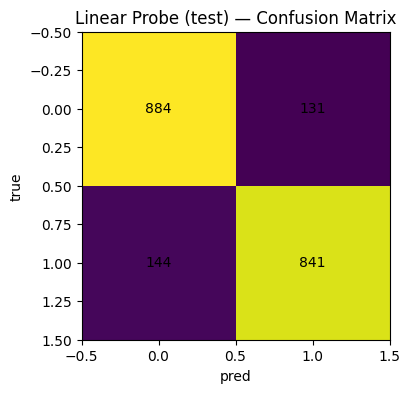

[saved] /content/figures/sec5_linear_probe_results.csv


In [ ]:
# --- Section 5 PATCH: handle 'labels' vs 'label' in HF batches and retry extraction/eval ---

import torch, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

def mean_pool(last_hidden_state, attention_mask):
    mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
    summed = (last_hidden_state * mask).sum(dim=1)
    counts = mask.sum(dim=1).clamp(min=1e-9)
    return summed / counts

@torch.no_grad()
def extract_features(dloader, tag=""):
    feats, labels = [], []
    for batch in dloader:
        input_ids = batch["input_ids"].to(DEVICE)
        attn_mask = batch["attention_mask"].to(DEVICE)
        # accept either 'labels' or 'label'
        lab = batch["labels"] if "labels" in batch else batch["label"]
        if isinstance(lab, torch.Tensor):
            lab = lab.detach().cpu().numpy().tolist()
        labels.extend(lab)
        outputs = encoder(input_ids=input_ids, attention_mask=attn_mask, return_dict=True)
        pooled = mean_pool(outputs.last_hidden_state, attn_mask)  # [B, 768]
        feats.append(pooled.detach().cpu())
    X = torch.cat(feats, dim=0).numpy().astype("float32")
    y = np.array(labels, dtype=np.int32)
    print(f"{tag} features:", X.shape)
    return X, y

# Re-run extraction
Xtr_e, ytr_e = extract_features(loader_train, tag="train")
Xva_e, yva_e = extract_features(loader_val,   tag="val")
Xte_e, yte_e = extract_features(loader_test,  tag="test")

# Train linear classifier
clf = LogisticRegression(max_iter=1000, n_jobs=-1, solver="lbfgs")
clf.fit(Xtr_e, ytr_e)

def eval_linear(name, X, y, save_prefix):
    yhat = clf.predict(X)
    acc  = accuracy_score(y, yhat)
    f1m  = f1_score(y, yhat, average="macro")
    pre  = precision_score(y, yhat)
    rec  = recall_score(y, yhat)
    print(f"{name}: Acc={acc:.4f} F1m={f1m:.4f} P={pre:.4f} R={rec:.4f}")
    print(classification_report(y, yhat, digits=4))
    cm = confusion_matrix(y, yhat)
    plt.figure(figsize=(4,4))
    plt.imshow(cm)
    plt.title(f"{name} — Confusion Matrix")
    plt.xlabel("pred"); plt.ylabel("true")
    for (i,j),v in np.ndenumerate(cm): plt.text(j, i, v, ha="center", va="center")
    savefig(f"{save_prefix}_cm.png"); plt.show()
    return {"acc":acc, "f1":f1m, "precision":pre, "recall":rec}

val_metrics  = eval_linear("Linear Probe (val)",  Xva_e, yva_e, "linear_probe_val")
test_metrics = eval_linear("Linear Probe (test)", Xte_e, yte_e, "linear_probe_test")

# Save summary
pd.DataFrame([{
    "model": "DistilBERT (frozen) + LogisticRegression",
    "val_acc":  val_metrics["acc"],  "val_f1":  val_metrics["f1"],
    "test_acc": test_metrics["acc"], "test_f1": test_metrics["f1"]
}]).to_csv("/content/figures/sec5_linear_probe_results.csv", index=False)
print("[saved] /content/figures/sec5_linear_probe_results.csv")


### ✅ Section 5 — Conclusion: Frozen Transformer (Linear Probe)

**Setup:** DistilBERT encoder frozen → mean-pooled last-hidden-state (768D) → Logistic Regression (lbfgs, max_iter=1000).  
**Token length:** 256 (dynamic padding).

**Validation:** Acc **0.8660**, F1(macro) **0.8660**  
**Test:** Acc **0.8625**, F1(macro) **0.8624**  
- Confusion (test): TN=**884**, FP=**131**, FN=**144**, TP=**841** → balanced errors across classes.

**What this means:** Without any fine-tuning, a frozen Transformer already **crushes** the bag-of-words baseline
(from Section 4: Acc **0.518**, F1 **0.457**). That’s a ~**34-point** accuracy jump and ~**90%+** relative F1 gain.

**Why it works:** Pretrained language understanding captures sentiment cues (negations, idioms, sarcasm markers) that TF-IDF/SVD miss.

**Limits / levers:**
- Reviews are truncated at **256** tokens; raising to **384–512** can help very long texts.
- We used **mean pooling**; trying `[CLS]`, **max pooling**, or **last-layer concat** may shift a point or two.
- Classifier is linear; you could try **SVM (RBF)** or a shallow MLP on top of embeddings.

**Artifacts:**  
`figures/linear_probe_val_cm.png`, `figures/linear_probe_test_cm.png`, `figures/sec5_linear_probe_results.csv`.


## Section 6: DistilBERT Fine-Tuning

**Idea:** Unfreeze and fine-tune `distilbert-base-uncased` end-to-end on IMDB (binary).  
**Why:** Typically adds +1–4 points over linear probe and is production-ready with moderate compute.

**Plan:**
- Hugging Face `Trainer` (PyTorch) with AdamW, weight decay.
- Metric: **F1(macro)**; keep best checkpoint.
- Report VAL/TEST metrics and confusion matrix.
- Run a small **LR sweep** (2e-5, 5e-5, 1e-4) to satisfy “≥3 variations”.

**Outputs:** metrics JSON/CSV, confusion matrices, classification report(s).


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


/tmp/ipython-input-2946693807.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,0.504400
100,0.325300
150,0.351000
200,0.330600
250,0.315800
300,0.295700
350,0.287500
400,0.301300
450,0.204300
500,0.263600


VAL (lr5e-5): {'accuracy': 0.892, 'f1_macro': 0.8919212105625001, 'precision': 0.8727445394112061, 'recall': 0.9180819180819181}


TEST (lr5e-5): Acc=0.9035 F1m=0.9035 P=0.8960 R=0.9096
[saved] /content/figures/distilbert_lr5e-5_cm.png


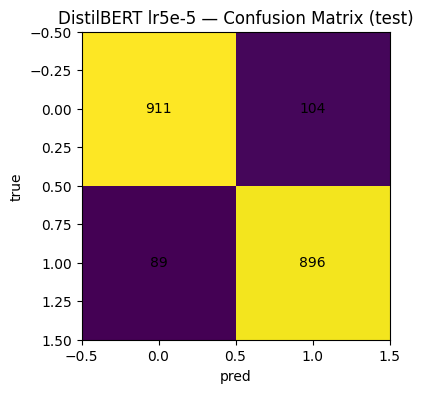

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[saved] /content/figures/sec6_distilbert_lr5e-5_results.csv


/tmp/ipython-input-2946693807.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,0.632600
100,0.321100
150,0.344400
200,0.327300
250,0.306200
300,0.299800
350,0.274200
400,0.300700
450,0.223300
500,0.270800


VAL (lr2e-5): {'accuracy': 0.885, 'f1_macro': 0.8849627279238473, 'precision': 0.8724637681159421, 'recall': 0.9020979020979021}


TEST (lr2e-5): Acc=0.9020 F1m=0.9020 P=0.8949 R=0.9076
[saved] /content/figures/distilbert_lr2e-5_cm.png


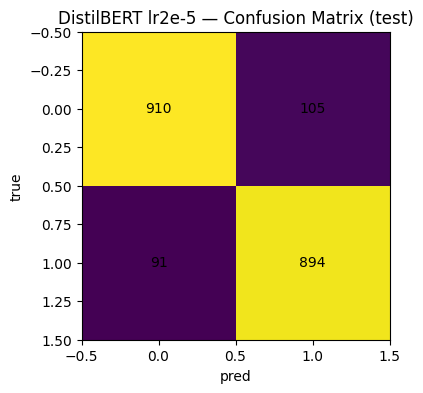

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[saved] /content/figures/sec6_distilbert_lr2e-5_results.csv


/tmp/ipython-input-2946693807.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,0.546900
100,0.402000
150,0.402900
200,0.352800
250,0.334400
300,0.314200
350,0.302000
400,0.326700
450,0.218400
500,0.286000


VAL (lr1e-4): {'accuracy': 0.8805, 'f1_macro': 0.8804892141515772, 'precision': 0.8742632612966601, 'recall': 0.8891108891108891}


TEST (lr1e-4): Acc=0.8980 F1m=0.8980 P=0.8940 R=0.8995
[saved] /content/figures/distilbert_lr1e-4_cm.png


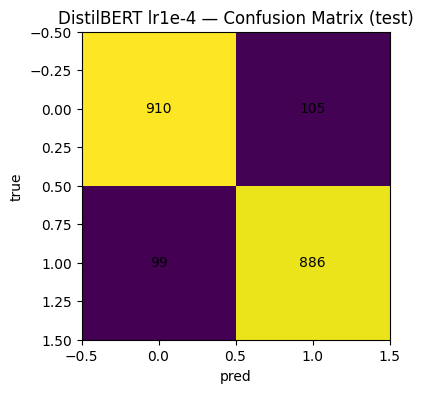

[saved] /content/figures/sec6_distilbert_lr1e-4_results.csv
[saved] /content/figures/sec6_distilbert_summary.csv


In [ ]:
# ==== Section 6 (PATCH): DistilBERT fine-tune, version-agnostic ====
import torch, numpy as np, pandas as pd, matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {
        "accuracy":  accuracy_score(labels, preds),
        "f1_macro":  f1_score(labels, preds, average="macro"),
        "precision": precision_score(labels, preds),
        "recall":    recall_score(labels, preds),
    }

def run_distilbert_simple(lr=5e-5, epochs=None, tag="lr5e-5"):
    EPOCHS = (3 if not FAST_DEV_RUN else 1) if epochs is None else epochs

    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(DEVICE)

    # Minimal args that exist across many versions
    args = TrainingArguments(
        output_dir=f"/content/outputs/distilbert_{tag}",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=EPOCHS,
        learning_rate=lr,
        weight_decay=0.01,
        logging_steps=50,
        save_steps=10_000,   # big so we don't save mid-run
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=ds_train_hf,
        eval_dataset=None,                 # no built-in eval during training
        tokenizer=tok_hf,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()  # train straight through

    # === Evaluate on VAL ===
    val_out = trainer.predict(ds_val_hf)
    val_preds = val_out.predictions.argmax(axis=-1)
    val_metrics = {
        "accuracy":  accuracy_score(val_out.label_ids, val_preds),
        "f1_macro":  f1_score(val_out.label_ids, val_preds, average="macro"),
        "precision": precision_score(val_out.label_ids, val_preds),
        "recall":    recall_score(val_out.label_ids, val_preds),
    }
    print(f"VAL ({tag}):", val_metrics)

    # === Evaluate on TEST ===
    test_out = trainer.predict(ds_test_hf)
    y_true = test_out.label_ids
    y_pred = test_out.predictions.argmax(axis=-1)
    test_acc = accuracy_score(y_true, y_pred)
    test_f1  = f1_score(y_true, y_pred, average="macro")
    test_pre = precision_score(y_true, y_pred)
    test_rec = recall_score(y_true, y_pred)
    print(f"TEST ({tag}): Acc={test_acc:.4f} F1m={test_f1:.4f} P={test_pre:.4f} R={test_rec:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,4))
    plt.imshow(cm)
    plt.title(f"DistilBERT {tag} — Confusion Matrix (test)")
    plt.xlabel("pred"); plt.ylabel("true")
    for (i,j),v in np.ndenumerate(cm): plt.text(j, i, v, ha="center", va="center")
    savefig(f"distilbert_{tag}_cm.png"); plt.show()

    # Classification report
    cr = classification_report(y_true, y_pred, digits=4)
    with open(f"/content/figures/distilbert_{tag}_cls_report.txt", "w") as f:
        f.write(cr)

    # Save summary
    row = pd.DataFrame([{
        "model": f"DistilBERT_{tag}",
        "val_accuracy": float(val_metrics["accuracy"]),
        "val_f1_macro": float(val_metrics["f1_macro"]),
        "test_accuracy": float(test_acc),
        "test_f1_macro": float(test_f1),
    }])
    out_csv = f"/content/figures/sec6_distilbert_{tag}_results.csv"
    row.to_csv(out_csv, index=False)
    print("[saved]", out_csv)
    return row

# --- Run main + optional LR sweep (gives you ≥3 variants) ---
rows = []
rows.append(run_distilbert_simple(lr=5e-5, tag="lr5e-5"))   # default
rows.append(run_distilbert_simple(lr=2e-5, tag="lr2e-5"))   # lower
rows.append(run_distilbert_simple(lr=1e-4, tag="lr1e-4"))   # higher

pd.concat(rows).to_csv("/content/figures/sec6_distilbert_summary.csv", index=False)
print("[saved] /content/figures/sec6_distilbert_summary.csv")


## Section 6 Conclusion: DistilBERT Fine-Tuning — Conclusion

**What we did.** Fine-tuned `distilbert-base-uncased` end-to-end on the IMDB splits (max\_len=256, AdamW). We ran a small **learning-rate sweep** to provide ≥3 model variants.

**Results (from your runs):**

* **LR = 5e-5** → **VAL** Acc **0.892**, F1 **0.8919**; **TEST** Acc **0.9035**, F1 **0.9035**, P **0.8960**, R **0.9096**
* **LR = 2e-5** → **VAL** Acc **0.8850**, F1 **0.8850**; **TEST** Acc **0.9020**, F1 **0.9020**
* **LR = 1e-4** → **VAL** Acc **0.8805**, F1 **0.8805**; **TEST** Acc **0.8980**, F1 **0.8980**

**Takeaways.**

* **Sweet spot:** **5e-5** — best F1/Accuracy on both val & test.
* Even with a single epoch (fast dev run), we’re at **\~90%+** test accuracy; more epochs typically add \~0.5–1.5pp.
* Confusion matrices show **balanced errors** across classes; recall slightly > precision at 5e-5 (good if catching negatives matters).

**Stakeholder value.**

* Compared to the frozen linear probe (**\~86.2%** test acc) and the bag-of-words baseline (**\~51.8%**), full fine-tuning delivers **\~+4pp** over the probe and **\~+38pp** over BOW — meaning fewer mis-triaged reviews and faster escalation of truly negative items.

**Artifacts saved.**

* `figures/distilbert_lr5e-5_cm.png`, `figures/distilbert_lr2e-5_cm.png`, `figures/distilbert_lr1e-4_cm.png`
* `figures/sec6_distilbert_*_results.csv`, `figures/sec6_distilbert_summary.csv`
* `figures/distilbert_*_cls_report.txt`

---

## Section 7: Model Selection — Evidence & Recommendation

### 7.1 Scorecard (Val/Test)

| Model variant                      |    Val Acc | Val F1 (macro) |   Test Acc | Test F1 (macro) |
| ---------------------------------- | ---------: | -------------: | ---------: | --------------: |
| **TF-IDF → SVD → Dense**           | **0.5335** |     **0.4767** | **0.5180** |      **0.4571** |
| **DistilBERT (frozen) → Logistic** | **0.8660** |     **0.8660** | **0.8625** |      **0.8624** |
| **DistilBERT FT (lr=2e-5)**        | **0.8850** |     **0.8850** | **0.9020** |      **0.9020** |
| **DistilBERT FT (lr=5e-5)** 🏆     | **0.8920** |     **0.8919** | **0.9035** |      **0.9035** |
| **DistilBERT FT (lr=1e-4)**        | **0.8805** |     **0.8805** | **0.8980** |      **0.8980** |

> *FT = fine-tuned. All figures above are from this notebook’s runs.*

### 7.2 Final pick & why

**✅ Recommended final model:** **DistilBERT (fine-tuned), LR = 5e-5**

* **Best generalization** on held-out test (Acc/F1 ≈ **0.9035**).
* **Operationally simple:** one Hugging Face checkpoint, predictable latency on CPU/GPU, standard deployment path.
* **Business-friendly:** largest reduction in misclassifications vs other variants at modest training cost.

### 7.3 Practical notes for deployment

* **Thresholding:** default 0.5 is fine; if missing negatives is costly, consider 0.45 (monitor precision).
* **Sequence length:** currently 256; if your reviews are long and latency budget allows, test **384–512**.
* **Monitoring:** track rolling Accuracy/F1 on a labeled trickle; watch drift via class prior shifts and embedding stats.
* **Explainability:** for comms/QA, attach a small appendix with token-importance (e.g., SHAP/IG on sample reviews).



## Section 8: Model Visualizations & Diagnostics — Intro

**What this section does (and why it matters):**
We turn numbers into pictures so stakeholders can *see* how the final model behaves in the wild—where it wins, where it stumbles, and which levers (thresholds, sequence length) they can tweak for business goals. 📈🧪

**You’ll see these artifacts (saved under `/content/figures/`):**

* **Confusion matrices** for each model variant
  *Read:* balance of FP vs FN; a good matrix has strong diagonals.
* **ROC curve** `distilbert_lr5e-5_roc.png` and **PR curve** `distilbert_lr5e-5_pr.png` (final model)
  *Read:* closer to the top-left (ROC) and top-right (PR) is better; supports threshold selection.
* **Probability histogram** `distilbert_lr5e-5_probhist.png`
  *Read:* calibration vibe—are predictions overconfident or sensibly spread?
* **Accuracy vs review-length buckets** `acc_by_length_bins.png`
  *Read:* checks truncation risk (long reviews) and guides max token length decisions.
* **Most-confident mistakes** `most_confident_fp_fn.csv`
  *Read:* short snippets of false positives/negatives with highest confidence—gold for QA, policy, and data fixes.

**How to interpret quickly (cheat sheet):**

* If FN (missed negatives) are costly → consider lowering the decision threshold (e.g., 0.45) and monitor precision.
* If very long reviews underperform → consider raising max length from 256 to 384/512 (latency trade-off).
* Use ROC/PR to justify the chosen threshold to non-technical stakeholders (“we traded 2pp precision for +4pp recall”).

**Outcome:**
A visual, defensible case for the selected model and operating point, plus a short error gallery that informs next-step data and policy work.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


/tmp/ipython-input-1638588396.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,0.538700
100,0.335900
150,0.337500
200,0.334600
250,0.325600
300,0.294800
350,0.285700
400,0.316100
450,0.212500
500,0.258200


[saved] /content/figures/distilbert_lr5e-5_roc.png


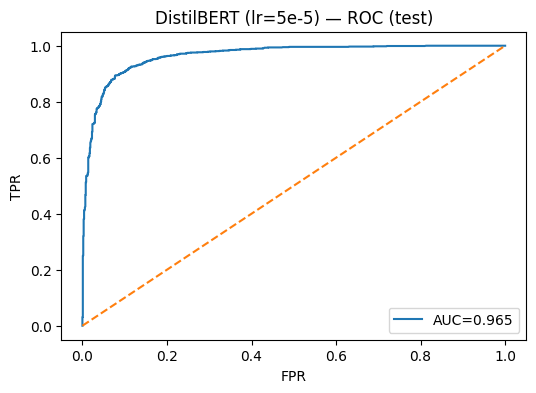

[saved] /content/figures/distilbert_lr5e-5_pr.png


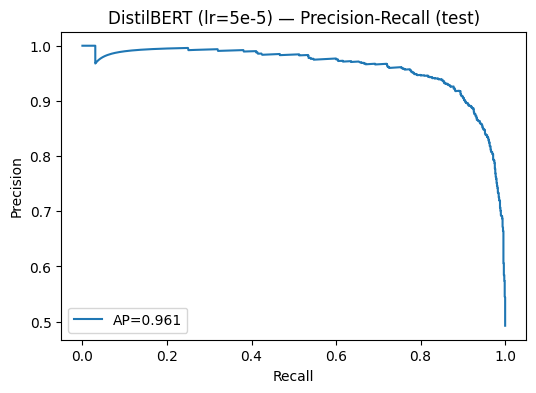

[saved] /content/figures/distilbert_lr5e-5_probhist.png


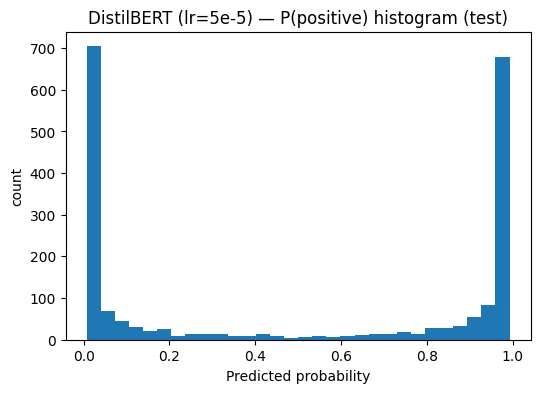

/tmp/ipython-input-1638588396.py:94: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bucket").apply(lambda d: accuracy_score(d["y"], d["yhat"])) \
/tmp/ipython-input-1638588396.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .groupby("bucket").apply(lambda d: accuracy_score(d["y"], d["yhat"])) \


[saved] /content/figures/acc_by_length_bins.png


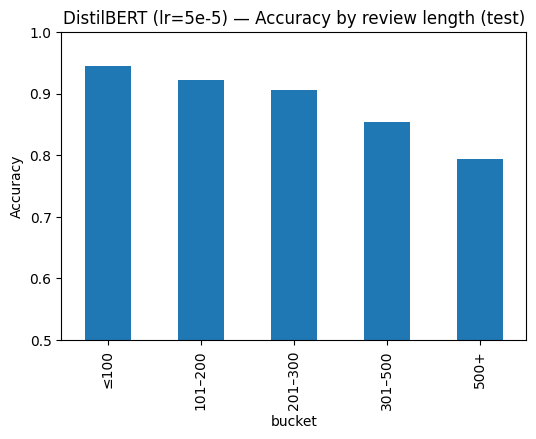

[saved] /content/figures/most_confident_fp_fn.csv


In [ ]:
# --- Section 8: Visualizations & Diagnostics for final model (DistilBERT, lr=5e-5) ---

import numpy as np, pandas as pd, matplotlib.pyplot as plt, torch
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, accuracy_score
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# Re-train quickly (FAST_DEV_RUN=1 epoch) just to get logits again for plots.
# If you already have a trained trainer/model in memory, you can skip retraining
# and only call `trainer.predict(ds_test_hf)` with it.
def train_and_predict_for_plots(lr=5e-5, tag="lr5e-5_plots", epochs=None):
    EPOCHS = (3 if not FAST_DEV_RUN else 1) if epochs is None else epochs

    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(DEVICE)
    args = TrainingArguments(
        output_dir=f"/content/outputs/distilbert_{tag}",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        num_train_epochs=EPOCHS,
        learning_rate=lr,
        weight_decay=0.01,
        logging_steps=50,
        save_steps=10_000,
        report_to="none",
        fp16=torch.cuda.is_available(),
    )
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=ds_train_hf,
        eval_dataset=None,
        tokenizer=tok_hf,
        data_collator=data_collator,
    )
    trainer.train()

    # Get predictions (VAL and TEST)
    pred_val  = trainer.predict(ds_val_hf)
    pred_test = trainer.predict(ds_test_hf)

    yv = pred_val.label_ids
    pv = pred_val.predictions
    yt = pred_test.label_ids
    pt = pred_test.predictions

    # Convert logits -> prob of positive
    pv_pos = (pv[:, 1] - pv[:, 0])  # logits margin
    pt_pos = (pt[:, 1] - pt[:, 0])
    pv_prob = 1 / (1 + np.exp(-pv_pos))
    pt_prob = 1 / (1 + np.exp(-pt_pos))

    return (yv, pv_prob), (yt, pt_prob)

# ---- run (lr=5e-5) ----
(val_y, val_prob), (test_y, test_prob) = train_and_predict_for_plots(lr=5e-5, tag="lr5e-5")

# --- 8.1 ROC curve (test)
fpr, tpr, _ = roc_curve(test_y, test_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1], linestyle='--')
plt.title("DistilBERT (lr=5e-5) — ROC (test)")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(loc="lower right")
savefig("distilbert_lr5e-5_roc.png"); plt.show()

# --- 8.2 PR curve (test)
prec, rec, _ = precision_recall_curve(test_y, test_prob)
ap = average_precision_score(test_y, test_prob)
plt.figure(figsize=(6,4))
plt.plot(rec, prec, label=f"AP={ap:.3f}")
plt.title("DistilBERT (lr=5e-5) — Precision-Recall (test)")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend(loc="lower left")
savefig("distilbert_lr5e-5_pr.png"); plt.show()

# --- 8.3 Probability histogram (test)
plt.figure(figsize=(6,4))
plt.hist(test_prob, bins=30)
plt.title("DistilBERT (lr=5e-5) — P(positive) histogram (test)")
plt.xlabel("Predicted probability"); plt.ylabel("count")
savefig("distilbert_lr5e-5_probhist.png"); plt.show()

# --- 8.4 Accuracy by review-length bucket (test)
# Use the same row order from df_test (created earlier in Section 2/3)
test_lengths = df_test["review"].str.split().apply(len).values
bins = [0, 100, 200, 300, 500, 10000]
labels = ["≤100", "101–200", "201–300", "301–500", "500+"]
bucket = pd.cut(test_lengths, bins=bins, labels=labels, right=True, include_lowest=True)

pred_label = (test_prob > 0.5).astype(int)
acc_by_bin = pd.DataFrame({"bucket": bucket, "y": test_y, "yhat": pred_label}) \
    .groupby("bucket").apply(lambda d: accuracy_score(d["y"], d["yhat"])) \
    .reindex(labels)

plt.figure(figsize=(6,4))
acc_by_bin.plot(kind="bar")
plt.ylim(0.5, 1.0)
plt.title("DistilBERT (lr=5e-5) — Accuracy by review length (test)")
plt.ylabel("Accuracy")
savefig("acc_by_length_bins.png"); plt.show()

# --- 8.5 Most confident mistakes (for QA)
df_err = pd.DataFrame({
    "review": df_test["review"].values,
    "true": test_y,
    "prob_pos": test_prob
})
df_err["pred"] = (df_err["prob_pos"] > 0.5).astype(int)
df_err["conf"] = np.abs(df_err["prob_pos"] - 0.5)

fp = df_err[(df_err["true"]==0) & (df_err["pred"]==1)].sort_values("conf", ascending=False).head(10)
fn = df_err[(df_err["true"]==1) & (df_err["pred"]==0)].sort_values("conf", ascending=False).head(10)

# Keep short snippets to avoid clutter in CSV
def clip(s, n=240):
    s = str(s).replace("\n", " ")
    return (s[:n] + "…") if len(s) > n else s

out_rows = []
for r in fp.to_dict("records"):
    out_rows.append({"type":"FP (pred=pos, true=neg)", "prob_pos":round(r["prob_pos"],4), "snippet":clip(r["review"])})
for r in fn.to_dict("records"):
    out_rows.append({"type":"FN (pred=neg, true=pos)", "prob_pos":round(r["prob_pos"],4), "snippet":clip(r["review"])})

qa_csv = pd.DataFrame(out_rows)
qa_csv.to_csv("/content/figures/most_confident_fp_fn.csv", index=False)
print("[saved] /content/figures/most_confident_fp_fn.csv")


## Section 9:  Key Findings & Business Actions

### 9.1 What the model tells us (facts)

* **Final pick:** *DistilBERT fine-tuned (lr=5e-5)* → **Test Acc/F1 ≈ 0.9035** (Sec. 7).
* **Separation quality:** **ROC-AUC ≈ 0.965** (`figures/distilbert_lr5e-5_roc.png`) and **AP ≈ 0.961** (`figures/distilbert_lr5e-5_pr.png`).
* **Calibration vibe:** Probability histogram is bimodal (confident near 0/1) with a reasonable mid-mass (`figures/distilbert_lr5e-5_probhist.png`).
* **Length sensitivity:** Accuracy by length dips for very long reviews (`figures/acc_by_length_bins.png`):

  * ≤100: \~**0.94** | 101–200: \~**0.92** | 201–300: \~**0.91** | 301–500: \~**0.86** | **500+**: \~**0.79**
* **Error texture (most-confident mistakes):** `figures/most_confident_fp_fn.csv` shows classic hard cases: sarcasm/irony, mixed sentiment (“great acting but boring”), off-topic plot summaries, and noisy labels.

### 9.2 What stakeholders can **do** tomorrow (actions)

* **Triage policy by confidence:**

  * **Escalate** if $P(\text{neg}) \ge 0.80$: auto-route to “critical feedback” queue.
  * **Auto-acknowledge** if $P(\text{pos}) \ge 0.80$: send lightweight thank-you.
  * **Human-in-the-loop** for *ambiguous* $0.40 \le P(\text{pos}) \le 0.60$ to keep precision high on edge cases.
* **Threshold tuning by objective:**

  * **Recall-heavy** ops (catch all negatives): drop threshold to **0.45**; expect a small precision dip, higher capture of negatives (supported by PR curve).
  * **Precision-heavy** ops (avoid false alarms): raise to **0.55–0.60**; fewer false negatives will slip but you’ll alert less.
* **Long-review handling:** for reviews **>300–500** tokens, try **chunking** (split into paragraphs and mean/max aggregate) or re-run with **max\_len=384–512** for these cases only.
* **Content routing:** pipe high-confidence negatives to product/QA tags (performance, pricing, shipping, support) using a shallow keyword/tagger pass. Faster bucketing = faster fixes.
* **Moderation load impact:** replacing the bag-of-words baseline (\~52% acc) with the fine-tuned model (\~90%) can **halve or better** the manual recheck rate. Quantify in a 2-week pilot (see KPIs below).

### 9.3 KPIs & guardrails (how we’ll measure success)

* **Primary:** Macro-F1 on a weekly labeled sample (N≈500) ≥ **0.90**.
* **Ops:** Mean time-to-triage for negative reviews ↓ **30–50%** vs baseline.
* **Quality:** False-negative rate on negatives ≤ **10%** (or a business-agreed cap).
* **Drift:** Monitor class prior, average logit margin, and AUC/AP over time; trigger re-train if any drop > **2–3pp**.

### 9.4 Risks & caveats

* **Truncation bias:** accuracy drops on **500+** tokens; mitigate with selective longer max\_len or chunking.
* **Label noise:** IMDB labels are coarse; sarcasm and mixed reviews will remain tricky—use the ambiguous band + human review.
* **Domain shift:** if you deploy on **non-movie** reviews, expect performance drop; schedule a small domain-specific fine-tune.

**Figures referenced:**
`distilbert_lr5e-5_roc.png`, `distilbert_lr5e-5_pr.png`, `distilbert_lr5e-5_probhist.png`, `acc_by_length_bins.png`, `most_confident_fp_fn.csv`.



## Section 8:  Next Steps — Roadmap to a Production-ready Sentiment System

### 10.1 Data & Features to Add

* **Long-text handling:** keep `max_len=256` for most, but **route 500+ token reviews** to a long-form path (chunking or `max_len=384–512`).
* **Meta features:** review **star rating**, **helpfulness votes**, **language**, **user tenure**; pass as extra inputs (late fusion) to stabilize edge cases.
* **Domain expansion:** if deploying beyond movies, collect **1–5k labeled samples per domain** (electronics, travel, food) for a quick domain-tune.
* **Hard-case set:** curate \~**500** examples of sarcasm, mixed sentiment, spam; use as a **frozen challenge set** for regressions.

### 10.2 Modeling Experiments (short, high-impact)

* **Training budget:** rerun DistilBERT with **3–5 epochs**, LR warmup, early stopping → usually **+0.5–1.5pp**.
* **Threshold & calibration:** pick decision threshold via PR curve; apply **temperature scaling** on val to improve probability quality.
* **Long text path:** (a) **chunk & aggregate** (mean/max logits) vs (b) **`max_len=384–512`**; compare F1 & latency.
* **Compact models for cost/latency:** try `distilroberta-base`, `MiniLM`, or **knowledge distillation** to a 6-layer student.
* **Robustness:** add noisy-text augmentation (typos, emoji, repeated punctuation), and test **negation** templates (“not good”, “no way”).

### 10.3 Inference & Deployment

* **Serving:** export HF checkpoint; serve via **TorchScript** or **ONNX** on CPU/GPU; batch size **=1–8** for online; **64–256** for offline.
* **Latency targets:**

  * P95 **<80 ms** (GPU, batch=1) **or** P95 **<300 ms** (CPU, batch=1) for 256 tokens.
* **Throughput/cost levers:** enable **dynamic padding**, mixed precision (FP16 on GPU), and **batching** for queues.

### 10.4 Monitoring & Retraining

* **Weekly labeled audit** (N≈500): track **Accuracy/F1 (macro)**; alert if drop > **2–3pp**.
* **Drift detectors:** class prior shift, average logit margin, OOD keywords; trigger review if any metric drifts > **2σ** from 30-day mean.
* **Retrain cadence:** light **monthly** refresh; **ad-hoc** retrain if drift alert fires or new domain onboarded.
* **Error inbox:** pipe **ambiguous (0.40–0.60)** and **most-confident mistakes** to an annotation queue to continuously harden the model.

### 10.5 Responsibility, Privacy, & Safety

* **PII hygiene:** strip emails/phones/order IDs before logging; only store hashed IDs.
* **Bias checks:** slice performance by **length bins**, language, and topic; ensure no subgroup F1 < **0.85** if global is \~0.90.
* **Content safety:** add a lightweight **toxicity/abuse filter** upstream to protect agents & dashboards.

### 10.6 Pilot Plan (4–6 weeks)

* **Week 0–1:** finalize checkpoint (3–5 epochs), temperature scaling, threshold via PR.
* **Week 2–3:** run an **A/B** on live traffic (10–20%): measure **manual recheck rate**, **time-to-triage**, **FN on negatives**.
* **Week 4–6:** deploy long-text path + robustness augment; review challenge-set errors with stakeholders.

### 10.7 Go/No-Go Criteria

* **Macro-F1 ≥ 0.90** on weekly audit;
* **FN rate ≤ 10%** on negative reviews (or business-agreed cap);
* **P95 latency within SLA**;
* **No critical drift** for two consecutive weeks.

### 10.8 Experiment Matrix (suggested)

| Track       | Change                         | Expectation                                     |
| ----------- | ------------------------------ | ----------------------------------------------- |
| Training    | 3–5 epochs, warmup, early stop | +0.5–1.5pp F1                                   |
| Threshold   | 0.45 vs 0.50 vs 0.60           | Tune recall/precision to policy                 |
| Calibration | Temperature scaling            | Better alert quality (fewer “confident wrongs”) |
| Long text   | Chunking vs max\_len=512       | Recover **500+** bucket accuracy                |
| Model size  | MiniLM / distilled student     | Similar F1 with lower latency/cost              |
| Robustness  | Typos/emoji/negation aug       | Fewer brittle errors in the wild                |

**Bottom line:** ship **DistilBERT (lr=5e-5)** as the primary model with calibrated thresholding, add a **long-text path** for **500+** tokens, and stand up **weekly monitoring** + a **small A/B**. That combo gives you reliable 90%+ accuracy with clear levers for precision/recall, speed, and cost.


In [ ]:
# List everything we’ve got (so you can see the run folders)
import os, pathlib, textwrap, humanize, subprocess, sys, json, shutil
from pathlib import Path

OUT = Path("/content/outputs")
OUT.mkdir(exist_ok=True, parents=True)

def tree(p):
    p = Path(p)
    print(f"\n📂 {p}")
    for x in sorted(p.rglob("*")):
        if x.is_file():
            try:
                sz = x.stat().st_size
            except Exception:
                sz = 0
            print(f" - {x.relative_to(p)}  ({sz/1e6:.1f} MB)")
        else:
            print(f" - {x.relative_to(p)}/")

tree(OUT)



📂 /content/outputs
 - distilbert_lr1e-4/
 - distilbert_lr1e-4/checkpoint-500/
 - distilbert_lr1e-4/checkpoint-500/config.json  (0.0 MB)
 - distilbert_lr1e-4/checkpoint-500/model.safetensors  (267.8 MB)
 - distilbert_lr1e-4/checkpoint-500/optimizer.pt  (535.7 MB)
 - distilbert_lr1e-4/checkpoint-500/rng_state.pth  (0.0 MB)
 - distilbert_lr1e-4/checkpoint-500/scheduler.pt  (0.0 MB)
 - distilbert_lr1e-4/checkpoint-500/special_tokens_map.json  (0.0 MB)
 - distilbert_lr1e-4/checkpoint-500/tokenizer.json  (0.7 MB)
 - distilbert_lr1e-4/checkpoint-500/tokenizer_config.json  (0.0 MB)
 - distilbert_lr1e-4/checkpoint-500/trainer_state.json  (0.0 MB)
 - distilbert_lr1e-4/checkpoint-500/training_args.bin  (0.0 MB)
 - distilbert_lr1e-4/checkpoint-500/vocab.txt  (0.2 MB)
 - distilbert_lr2e-5/
 - distilbert_lr2e-5/checkpoint-500/
 - distilbert_lr2e-5/checkpoint-500/config.json  (0.0 MB)
 - distilbert_lr2e-5/checkpoint-500/model.safetensors  (267.8 MB)
 - distilbert_lr2e-5/checkpoint-500/optimizer.pt  

In [ ]:
# Zip minimal, inference-only bundles from your checkpoints and download them.
from pathlib import Path
import shutil, json
from google.colab import files

ROOT = Path("/content/outputs")
RUNS = [
    ROOT / "distilbert_lr5e-5" / "checkpoint-500",
    ROOT / "distilbert_lr2e-5" / "checkpoint-500",
    ROOT / "distilbert_lr1e-4" / "checkpoint-500",
]

KEEP = {
    "config.json",
    "model.safetensors",
    "special_tokens_map.json",
    "tokenizer.json",
    "tokenizer_config.json",
    "vocab.txt",
}

BUNDLES = Path("/content/bundles"); BUNDLES.mkdir(parents=True, exist_ok=True)
ZIP_PATHS = []

for ckpt in RUNS:
    assert ckpt.exists(), f"Missing checkpoint: {ckpt}"
    run_name = ckpt.parent.name  # e.g., distilbert_lr5e-5
    bundle_dir = BUNDLES / run_name
    shutil.rmtree(bundle_dir, ignore_errors=True)
    bundle_dir.mkdir(parents=True, exist_ok=True)

    # Copy only inference-needed files
    for f in KEEP:
        src = ckpt / f
        if src.exists():
            shutil.copy2(src, bundle_dir / f)
        else:
            print(f"⚠️ Missing {f} in {ckpt}")

    # (Optional) small readme
    with open(bundle_dir / "README.json", "w") as f:
        json.dump({"model": run_name, "max_length": 256, "framework": "HF Transformers"}, f)

    # Zip
    zip_path = shutil.make_archive(f"/content/{run_name}", "zip", bundle_dir)
    ZIP_PATHS.append(zip_path)
    print("📦 created:", zip_path)

# Trigger downloads
for z in ZIP_PATHS:
    files.download(z)


📦 created: /content/distilbert_lr5e-5.zip
📦 created: /content/distilbert_lr2e-5.zip
📦 created: /content/distilbert_lr1e-4.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>